*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Truss in the System

In this chapter, we'll use systems of linear equations to analyze trusses.

A **truss** is an assembly of beams connected by joints, usually designed to support a load. Many bridges and roofs are supported by trusses, and if you've ever participated in a model bridge competition, the structure you built was probably a truss.

This picture shows a **Warren truss**, the basis of many railroad bridge designs:

<img width="400" src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/VIEW_OF_BRIDGE_FROM_SOUTH_WITH_ONCOMING_CSX_LOCOMOTIVE_ON_TRACKS_BELOW%2C_LOOKING_NORTHEAST_-_Wills_Creek_Bollman_Bridge%2C_Spanning_CSX_tracks_at_T381%2C_Meyersdale%2C_Somerset_County%2C_HAER_PA%2C56-MEYER.V%2C2-2.tif/lossy-page1-800px-thumbnail.tif.jpg">

This structure is made of three connected triangles with horizontal beams across the top. It's supported by anchor points at each end, and it carries a deck that supports a roadway. The load on the truss includes the weight of the roadway, any vehicles on it, and the weight of the truss itself.

To model a structure like this, we'll make some simplifying assumptions:

- We'll treat the structure as two-dimensional, analyzing only one side of the truss.

- We'll assume the joints behave like **hinge pins** that connect members but allow them to rotate freely.

- We'll assume the load is applied only at the joints, not along the length of the members.

- We'll treat each member of the truss as a **spring** that pushes or pulls in response to stretching or compression, with force that depends on its size and material.

- We'll assume that the stretching and compression are small enough that the geometry of the truss is unchanged. 

These assumptions aren't fully realistic, but they're reasonable approximations.
With them, we can analyze the structure -- that is, for a given load, we can compute how much each member stretches or compresses, and how much force it exerts in response.

The goal is to find an **equilibrium**, where the external forces applied to the truss are exactly balanced by internal spring forces in the members.

To solve this system, we'll use **projection matrices**, which we saw in Section XXX, and we'll introduce **block matrices**, which are matrices that contain vectors or submatrices as elements.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/nb/nullspace.ipynb).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp

from utils import decorate, underride

from utils import gset, gget

## The Simplest Truss

We'll start with a truss that's about as simple as it can be, shown in the following diagram.

In [4]:
def make_vector(x, y):
    return sp.Matrix([x, y])

In [5]:
L = sp.symbols('L', positive=True)
pos_A = make_vector(-L, -L)
pos_B = make_vector(L, -L)   
pos_C = make_vector(0, 0)
nodes = pos_A, pos_B, pos_C

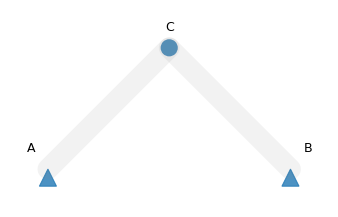

In [6]:
from utils import diagram_truss

subs = {L: 0.15}
diagram_truss(nodes, subs, lim=0.2)

The truss contains only two elements.
The one on the left is anchored at point A, the one on the right is anchored at point B, and they are connected to each other at point C.

The triangles represent anchors holding the points A and B in place.
The circle represents a pin joint that can move under load.

To start the analysis of this truss, we'll define symbols to represent the starting position of point C in two dimensions.

In [7]:
from sympy import symbols

x_C, y_C = symbols('x_C y_C')

And two more symbols to represent the displacement of point C from its starting position.
These are the unknowns we will solve for.

In [8]:
u_x, u_y = symbols('u_x u_y')

It will be convenient to pack these unknowns into a SymPy `Matrix` that represents a column vector.

In [9]:
u_C = make_vector(u_x, u_y)
u_C

Matrix([
[u_x],
[u_y]])

Similarly, we'll create matrices to represent the starting positions of points A, B, and C, based on `L`, which represents the length of one of the elements of the truss.

Next we'll compute the spring constant of the two elements, which is the product of the cross-sectional area, `A`, and the Young's modulus, `E`, divided by length `L`.

For this example, we'll assume that the cross-sectional area is the same but not necessarily the Young's modulus.
Here are the symbols we need:

In [10]:
A, E = symbols('A E', positive=True)

And the spring constants:

In [11]:
k_CA = A * E / L
k_CB = 2 * A * E / L

Next we'll compute vectors that represent the offset of A and B, relative to C.

In [12]:
r_CA = pos_A - pos_C
r_CB = pos_B - pos_C

Now, to compute the spring forces in the elements, we have to figure out what part of the displacement, `u`, is along the axis of each element.
We can do that by computing the vector projection of `u` onto `r_CA` and `r_CB`, as shown in this diagram.

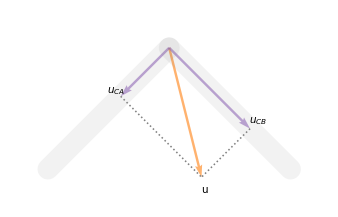

In [13]:
u = make_vector(2, -8) * 1e-6
scale = 2e4

diagram_truss(nodes, subs, u*scale, lim=0.2, add_pin=False, add_labels=False)

To compute the vector projection, we'll use this function, which:

1. Computes the unit vector in the direction of `r`, called `r_hat`,

2. Computes `r_hat.T * u`, which is the scalar magnitude of `u` in the direction of `r_hat`, and

3. Multiplies the result by `r_hat`.

The result is a vector that represents the component of `u` in the direction of `r`. 

In [14]:
def vector_projection(u, r):
    r_hat = r.normalized()
    scalar_projection = r_hat.T * u
    return r_hat * scalar_projection

To compute the spring forces in the elements, we multiply the spring constants by the scalar projections.

In [15]:
f_CA = -k_CA * vector_projection(u_C, r_CA)
f_CB = -k_CB * vector_projection(u_C, r_CB)

As an example, here's `f_CA`, which is a force vector.

In [16]:
from utils import factor_matrix

factor = -A * E / L / 2
factor_matrix(f_CA, factor)

(-A*E/(2*L))*Matrix([
[u_x + u_y],
[u_x + u_y]])

If the displacement is up and to the right, the components of `u_C` are positive.
In that case, the components of `f_CA` are negative -- so the reaction force is in the opposite direction as the displacement.

The total force due to this displacement is the sum of the reaction forces.

In [17]:
f_int = f_CA + f_CB

Let's suppose that the external force at `C` is a weight that pulls down in the `y` direction, with no additional force in the `x` direction.

In [18]:
F = symbols('F')
f_ext = make_vector(0, -F)

If the truss is not moving, the internal and external forces must be equal, so we can write this equation, which relates the external force to the spring forces.

In [19]:
eq = sp.Eq(-f_int, f_ext)

In [20]:
sp.Eq(factor_matrix(f_int, factor), f_ext)

Eq((-A*E/(2*L))*Matrix([
[ 3*u_x - u_y],
[-u_x + 3*u_y]]), Matrix([
[ 0],
[-F]]))

To analyze the truss, we want to find the displacement `u` that solves this equation.
First, let's plug in values for the symbols.

For `L`, we'll use the length of a popsicle stick in centimeters, and compute the location of `x_C` and `y_C` accordingly.

The Young's modulus of wood is about 3 gigapascal.

The cross-sectional area, `A`, is based on the approximate width and thickness of a popsicle stick.

Finally, let's suppose the external force is the weight of a one kilogram mass, which is roughly 9.8 N.

In [21]:
import pint
ureg = pint.UnitRegistry()

params = {
    L: 15.0 * ureg.cm,
    E: 3.0e9 * ureg.Pa,
    A: 1.0 * ureg.cm * 0.2 * ureg.cm,
    F: 9.8 * ureg.newton,
}

To substitute these values into the equation, we'll use this function, which makes a dictionary to map from symbols to their values, converted to base units.
So, for example, `L` in centimeters gets converted to meters, and `A` to square meters.

In [22]:
def make_subs(params):
    """Make a dictionary that maps from symbols to quantities."""
    return {sym: param.to_base_units().magnitude 
            for sym, param in params.items()}

In [23]:
subs = make_subs(params)
subs

{L: 0.15, E: 3000000000.0, A: 2e-05, F: 9.8}

Now we can express the equation numerically.

In [24]:
eq_num = eq.subs(subs).simplify()

And solve it.

In [25]:
sol = sp.solve(eq_num, u_C)

In [26]:
u_num = u_C.subs(sol)
sp.Eq(u_C, u_num * 1e6)

Eq(Matrix([
[u_x],
[u_y]]), Matrix([
[ -6.125],
[-18.375]]))

## The Stiffness Matrix

In the previous section, we wrote a vector equation with external force on the right and internal force on the left.
The SciPy `solve` function can solve the equation in this form, so it's sufficient to analyze the truss.  [TODO: Does solve have to rewrite it us a matrix equation?]

To write the left side us a matrix-vector product, we could factor out `u_x` and `u_y`.
Or we can go back and write it that way in the first place.
To do that, let's rethink the scalar projection.

$$\mathrm{proj}_{r} u = \hat{r}\, \hat{r}^T u$$


In `vector_projection`, we computed the scalar projection `r_hat.T u` first, to get the magnitude of the projection of `u` in the direction of `r`, and then multiplied by `r_hat`.
In other words, we evaluated the vector projection like this:

$$\mathrm{proj}_{r} u = \hat{r}\, (\hat{r}^T u)$$

As an alternative, we could have multiplied `r_hat` and `r_hat.T` first, like this:

$$\mathrm{proj}_{r} u = (\hat{r}\, \hat{r}^T) u$$

If `r_hat` is a column vector, the product of `r_hat` and `r_hat.T` is a matrix called a **projector**, which we can compute like this.

In [27]:
def projector(r):
    rhat = r.normalized()
    return rhat * rhat.T

As an example, here's the projector matrix for the vector `r_CA`.

In [28]:
P_CA = projector(r_CA)

In [29]:
factor = sp.Rational(1, 2)
factor_matrix(P_CA, factor)

(1/2)*Matrix([
[1, 1],
[1, 1]])

Now if we multiply `P_CA` and `u`, the result is the vector projection of `u_C` onto `r_CA`.

In [30]:
factor_matrix(P_CA * u_C, factor)

(1/2)*Matrix([
[u_x + u_y],
[u_x + u_y]])

But let's not combine `P_CA` and `U_C` yet; instead, we'll compute the projector matrix for the other element of the truss, `P_CB`.

In [31]:
P_CB = projector(r_CB)

If we multiply a projector matrix by the spring constant `k`, the result is a **stiffness matrix**.
So `k_CA * P_CA` is the stiffness matrix due to the truss element `CA` and
`k_CB * P_CB` is the stiffness matrix due to the truss element `CB`.
Their sum is the stiffness matrix for the whole truss, which we'll call `K`.


In [32]:
K = k_CA * P_CA + k_CB * P_CB
factor_matrix(K, A * E / L / 2)

(A*E/(2*L))*Matrix([
[ 3, -1],
[-1,  3]])

If you look closely at the symbolic representation of `K`, you can get some insight into its structure.
But at this point it will be easier to interpret if we convert it to a numerical array.

In [33]:
from utils import sympy_to_numpy

K_np = sympy_to_numpy(K, subs)
K_np

array([[ 600000., -200000.],
       [-200000.,  600000.]])

If we multiply `K` by a displacement vector, the result is a force vector that represents the internal force due to that displacement.
So one way to interpret the stiffness matrix is to test it with small displacements.
Here's an example where we displace node `C` by one micrometer in the `x` direction.

In [34]:
u_example1 = np.array([1, 0]) * 1e-6
f_example1 = -K_np @ u_example1
f_example1

array([-0.6,  0.2])

The restoring force is 0.6 N in the negative `x` direction and 0.2 N in the positive `y` direction.
And here's an example where we displace `C` by one micrometer in the `y` direction.

In [35]:
u_example2 = np.array([0, 1]) * 1e-6
f_example2 = -K_np @ u_example2
f_example2

array([ 0.2, -0.6])

The restoring force is about 0.2 N in the positive `x` direction and 0.6 N in the negative `y` direction.

More generally, we can use `K` to compute the force that results from any displacement.
To demonstrate, we'll make an array of 9 values from -20 to 20 micrometers.

In [36]:
scale = 1e-6
bound = 20
displacements = np.linspace(-bound, bound, 9) * scale
displacements

array([-2.0e-05, -1.5e-05, -1.0e-05, -5.0e-06,  0.0e+00,  5.0e-06,
        1.0e-05,  1.5e-05,  2.0e-05])

By enumerating all pairs of values, we'll make an array of 81 displacement vectors.

In [37]:
pairs = [(x, y) for x in displacements for y in displacements]
U = np.array(pairs).T 
U.shape

(2, 81)

`U` is matrix-like in the sense that it has two dimensions, but we are using it as a collection of vectors, not a matrix.
If we multiply by the stiffness matrix, the result is a collection of force vectors.

In [38]:
F_field = -K_np @ U
F_field.shape

(2, 81)

The following figure shows these results.
The location of each arrow shows a hypothetical displacement.
Each arrow shows the direction and relative magnitude of the resulting force due to displacement.
Note that the positions and forces are not in the same units, so the scale of the arrows is arbitrary.

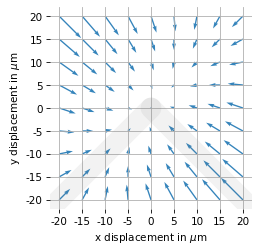

In [39]:
from utils import plot_vectors

diagram_truss(nodes, subs, add_pin=False, add_labels=False, axis='on')

options = dict(angles='xy', scale_units='xy', scale=3e-7)
plot_vectors(F_field.T, U.T, color='C0', alpha=0.9, **options)

lim2 = scale * (bound + 2)
plt.xlim(-lim2, lim2)
plt.ylim(-lim2, lim2)

ticks = np.arange(-20, 21, 5)
plt.xticks(displacements, ticks)
plt.yticks(displacements, ticks)

plt.xlabel('x displacement in $\mu$m')
plt.ylabel('y displacement in $\mu$m')
plt.grid(True)

Notice that the restoring forces are bigger in the upper left and lower right, which correspond to extension and compression of the stronger element of the truss.

In summary, multiplication by `K` is like a function: it takes a displacement vector and returns a corresponding force vector.
A function that maps vectors to other vectors is sometimes called a **vector field**.
And when those vectors represent forces, we call it a **force field**.

Finally, let's confirm that we get the same result using NumPy to solve $K u = f$.
First we'll convert the external force vector to an array.

In [40]:
f_ext_np = sympy_to_numpy(f_ext, subs)
f_ext_np

array([ 0. , -9.8])

And here's the solution.

In [41]:
import scipy

scipy.linalg.solve(K_np, f_ext_np) * 1e6

array([ -6.125, -18.375])

That's the same as the result we got before we factored out the stiffness matrix.

The key idea of this example is the use of the projector matrix to construct the stiffness matrix.
We'll use this idea again in the next example.

## Warren Trusses

So far we've been working with a simple truss with only two elements.
It contained only one node that could move, so we could analyze it with a vector equation with only two components.
Now let's try something a little harder -- we'll analyze a Warren truss.
We'll use NetworkX to represent the nodes and elements of the truss; then we'll construct a matrix equation that relates the displacements at the nodes to the external forces.

To specify the structure of the truss, we'll define `N`, which is the number of triangles in the truss, `L`, which is the length of the elements, and `H`, which is the height of the triangles.
We'll assume that all elements are the same length, so the triangles are equilateral.

In [42]:
N = 6
L = sp.Symbol('L', positive=True)
H = L * sp.sqrt(3) / sp.Rational(2)
H

sqrt(3)*L/2

Now let's make the graph.
To understand the code in this section, you might find it helpful to look ahead to the diagram that shows the results.

In [43]:
G = nx.Graph()

First we'll create the nodes that run along the bottom of the truss and the edges that connect them.

In [44]:
origin = make_vector(0, 0)

for i in range(N + 1):
    pos = origin + make_vector(i * L, 0)
    G.add_node(f'B{i}', pos=pos)
    if i > 0:
        G.add_edge(f'B{i-1}', f'B{i}')

The bottom nodes are assigned positions based on `L`, and labeled with strings like `B0`, `B1`, etc.

Now we'll add the nodes that run along the top, the horizontal edges that connect them, and the diagonal edges that connect the top and bottom nodes.

In [45]:
for i in range(N):
    pos = origin + make_vector((i + sp.Rational(1, 2)) * L, H)
    G.add_node(f'T{i}', pos=pos)
    G.add_edge(f'B{i}', f'T{i}')
    G.add_edge(f'T{i}', f'B{i+1}')

    if i > 0:
        G.add_edge(f'T{i-1}', f'T{i}')

The top nodes are assigned positions based on `L` and `H`, and labeled `T0`, `T1`, etc.
Here's what the graph looks like.

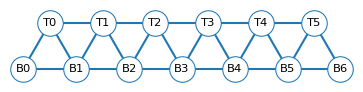

In [46]:
from utils import draw_truss_graph

draw_truss_graph(G, {L: 0.15})

For reasons we'll see later, it will be convenient if every node has a unique index starting from `0`.
So we'll loop through the nodes and use `gset` to assign each node an index.

In [47]:
for i, node in enumerate(G.nodes):
    gset(G, node, index=i)

Now we'll loop through the nodes and assign a displacement vector to each one.


In [48]:
for node in G.nodes():
    ux, uy = sp.symbols(f'u_{node}_x u_{node}_y')    
    disp = make_vector(ux, uy)
    gset(G, node, disp=disp)

We'll assume that the first and last nodes in the bottom row are fixed.

In [49]:
gset(G, )

For this example, we'll assume that the roadway is attached to the bottom nodes.
To keep things simple, we'll ignore the weight of the truss itself and assume that the load it attached to a single node, `B1`.
The following loop creates a force vector for each node in the truss and assigns it to an attribute called `f_ext`.

In [50]:
F = sp.Symbol('F')
weighted = ['B1']

for node in G.nodes:
    if node in weighted:
        gset(G, node, f_ext=make_vector(0, -F))
    else:
        gset(G, node, f_ext=make_vector(0, 0))

Finally, for each element of the truss, we'll compute ...



In [51]:
for edge in G.edges:
    node1, node2 = edge
    x1 = G.nodes[node1]['pos']
    x2 = G.nodes[node2]['pos']
    r = x2 - x1
    P = projector(r)
    gset(G, edge, P=P)

To keep this example simple, these attributes are the same for every element, but we could easily swap in different values.

## Block Matrix Equation

At this point we have a NetworkX graph that represents the nodes and elements of the truss.
The next step is to write a matrix equation to relate the unknown displacements to the internal and external forces.
To do that, we will construct a **block matrix** which is a way to represent a system of equations where the unknowns are vectors.

To show the structure of the problem, we'll start with a vector of displacements, where each displacement is itself a vector.

In [52]:
blocks = [sp.MatrixSymbol(f'u_{{{node}}}', 2, 1) for node in G.nodes]
u_block = sp.BlockMatrix([[u] for u in blocks])
u_block

Matrix([
[u_{B0}],
[u_{B1}],
[u_{B2}],
[u_{B3}],
[u_{B4}],
[u_{B5}],
[u_{B6}],
[u_{T0}],
[u_{T1}],
[u_{T2}],
[u_{T3}],
[u_{T4}],
[u_{T5}]])

And another vector that represents the external forces on the nodes.

In [53]:
blocks = [sp.MatrixSymbol(f'f_{{{node}}}', 2, 1) for node in G.nodes]
f_block = sp.BlockMatrix([[f] for f in blocks])
f_block

Matrix([
[f_{B0}],
[f_{B1}],
[f_{B2}],
[f_{B3}],
[f_{B4}],
[f_{B5}],
[f_{B6}],
[f_{T0}],
[f_{T1}],
[f_{T2}],
[f_{T3}],
[f_{T4}],
[f_{T5}]])

Now we'll create a block matrix where each element is a stiffness matrix -- the element $K_{ij}$ represents the stiffness at node $i$ due to its connection to node $j$.

In [54]:
def Ksym(i, j):
    return sp.MatrixSymbol(f'K_{i}{j}', 2, 2)

In [55]:
n = len(G.nodes)
blocks = [[Ksym(i, j) for j in range(n)] for i in range(n)]
K_block = sp.BlockMatrix(blocks)
K_block

Matrix([
[ K_00,  K_01,  K_02,  K_03,  K_04,  K_05,  K_06,  K_07,  K_08,  K_09,  K_010,  K_011,  K_012],
[ K_10,  K_11,  K_12,  K_13,  K_14,  K_15,  K_16,  K_17,  K_18,  K_19,  K_110,  K_111,  K_112],
[ K_20,  K_21,  K_22,  K_23,  K_24,  K_25,  K_26,  K_27,  K_28,  K_29,  K_210,  K_211,  K_212],
[ K_30,  K_31,  K_32,  K_33,  K_34,  K_35,  K_36,  K_37,  K_38,  K_39,  K_310,  K_311,  K_312],
[ K_40,  K_41,  K_42,  K_43,  K_44,  K_45,  K_46,  K_47,  K_48,  K_49,  K_410,  K_411,  K_412],
[ K_50,  K_51,  K_52,  K_53,  K_54,  K_55,  K_56,  K_57,  K_58,  K_59,  K_510,  K_511,  K_512],
[ K_60,  K_61,  K_62,  K_63,  K_64,  K_65,  K_66,  K_67,  K_68,  K_69,  K_610,  K_611,  K_612],
[ K_70,  K_71,  K_72,  K_73,  K_74,  K_75,  K_76,  K_77,  K_78,  K_79,  K_710,  K_711,  K_712],
[ K_80,  K_81,  K_82,  K_83,  K_84,  K_85,  K_86,  K_87,  K_88,  K_89,  K_810,  K_811,  K_812],
[ K_90,  K_91,  K_92,  K_93,  K_94,  K_95,  K_96,  K_97,  K_98,  K_99,  K_910,  K_911,  K_912],
[K_100, K_101, K_102, K_103, K_

Here's the matrix equation that relates these elements.

In [56]:
equation = sp.Eq(K_block * u_block, f_block)
equation

Eq(Matrix([
[ K_00,  K_01,  K_02,  K_03,  K_04,  K_05,  K_06,  K_07,  K_08,  K_09,  K_010,  K_011,  K_012],
[ K_10,  K_11,  K_12,  K_13,  K_14,  K_15,  K_16,  K_17,  K_18,  K_19,  K_110,  K_111,  K_112],
[ K_20,  K_21,  K_22,  K_23,  K_24,  K_25,  K_26,  K_27,  K_28,  K_29,  K_210,  K_211,  K_212],
[ K_30,  K_31,  K_32,  K_33,  K_34,  K_35,  K_36,  K_37,  K_38,  K_39,  K_310,  K_311,  K_312],
[ K_40,  K_41,  K_42,  K_43,  K_44,  K_45,  K_46,  K_47,  K_48,  K_49,  K_410,  K_411,  K_412],
[ K_50,  K_51,  K_52,  K_53,  K_54,  K_55,  K_56,  K_57,  K_58,  K_59,  K_510,  K_511,  K_512],
[ K_60,  K_61,  K_62,  K_63,  K_64,  K_65,  K_66,  K_67,  K_68,  K_69,  K_610,  K_611,  K_612],
[ K_70,  K_71,  K_72,  K_73,  K_74,  K_75,  K_76,  K_77,  K_78,  K_79,  K_710,  K_711,  K_712],
[ K_80,  K_81,  K_82,  K_83,  K_84,  K_85,  K_86,  K_87,  K_88,  K_89,  K_810,  K_811,  K_812],
[ K_90,  K_91,  K_92,  K_93,  K_94,  K_95,  K_96,  K_97,  K_98,  K_99,  K_910,  K_911,  K_912],
[K_100, K_101, K_102, K_103,

In an ideal world, we would write the equation this way and solve it, but we don't have solvers that can work on a system where the elements are vectors and matrices.
But we can use SymPy's `BlockMatrix` object to construct the system, and then convert it into  a conventional matrix with one row for each component of the unknown displacements.

## Compute the Block Matrix

To construct the block matrix, we'll loop through the edges and compute a matrix that represents the stiffness of each node due to the nodes it is connected to.
We'll start by working through a single example, arbitrarily choosing the edge from `B0` to `T0`.
We can use `gget` to get the direction vector and spring constant for this member of the truss.

In [57]:
edge = 'B0', 'T0'
P = gget(G, edge, "P")
P

Matrix([
[      1/4, sqrt(3)/4],
[sqrt(3)/4,       3/4]])

Next we'll get the displacements of the nodes.

In [58]:
node1, node2 = edge
u1 = gget(G, node1, "disp")
u2 = gget(G, node2, "disp")

If both ends of the member are displaced, the total extension or compression is the difference between the displacements, `u1 - u2`.
So we can compute the internal force in the member like this.

In [59]:
k = sp.symbols("k")
k = A * E / L

f_int = -k * P * (u1 - u2)
factor_matrix(f_int, A*E/L/4)

(A*E/(4*L))*Matrix([
[    -u_B0_x + u_T0_x - sqrt(3)*(u_B0_y - u_T0_y)],
[-3*u_B0_y + 3*u_T0_y - sqrt(3)*(u_B0_x - u_T0_x)]])

But to construct the block matrix, we'll keep the stiffness matrix and the displacement vector separate, like this:

In [60]:
sp.MatMul(factor_matrix(-k * P, k/4), u1 - u2, evaluate=False)

((A*E/(4*L))*Matrix([
[      -1, -sqrt(3)],
[-sqrt(3),       -3]]))*Matrix([
[u_B0_x - u_T0_x],
[u_B0_y - u_T0_y]])

Now we're ready to assemble the block matrix.
We'll start with a list of lists, where each element is a stiffness matrix full of zeroes.
As we loop through the edges, we'll add to these matrices.

In [61]:
blocks = [[sp.Matrix.zeros(2, 2) for _ in range(n)] for _ in range(n)]

Now here's the key to the whole operation.
We loop through the edges and compute a matrix that represents the stiffness at node `i` due to its connection to `j`.
Then we add that matrix to the block ...

In [62]:
def add_block(i, j, kP):
    blocks[i][i] +=  kP
    blocks[i][j] += -kP

In [63]:
for edge in G.edges:
    P = gget(G, edge, "P")
    
    node1, node2 = edge
    i = gget(G, node1, 'index')
    j = gget(G, node2, 'index')

    # Insert contributions for edge (i, j)
    add_block(i, j, k * P)
    add_block(j, i, k * P)

The result is a list of lists of matrices, each the sum of some number of stiffness matrices.
We can use the list of lists to make a `BlockMatrix`.
Here's the result, shown with the common factor $k/4$ pulled out.

In [64]:
K_block = sp.BlockMatrix(blocks)
factor_matrix(K_block, factor=k/4)

(A*E/(4*L))*Matrix([
[    Matrix([
[      5, sqrt(3)],
[sqrt(3),       3]]),                           Matrix([
[-4, 0],
[ 0, 0]]),                             Matrix([
[0, 0],
[0, 0]]),                             Matrix([
[0, 0],
[0, 0]]),                             Matrix([
[0, 0],
[0, 0]]),                             Matrix([
[0, 0],
[0, 0]]),                             Matrix([
[0, 0],
[0, 0]]), Matrix([
[      -1, -sqrt(3)],
[-sqrt(3),       -3]]),                             Matrix([
[0, 0],
[0, 0]]),                             Matrix([
[0, 0],
[0, 0]]),                             Matrix([
[0, 0],
[0, 0]]),                             Matrix([
[0, 0],
[0, 0]]),                             Matrix([
[0, 0],
[0, 0]])],
[                          Matrix([
[-4, 0],
[ 0, 0]]),                           Matrix([
[10, 0],
[ 0, 6]]),                           Matrix([
[-4, 0],
[ 0, 0]]),                             Matrix([
[0, 0],
[0, 0]]),                             Matrix([
[0, 

Now let's see if we can solve the matrix equation $K u = f$. 

## Shift and Rotate

At this point we have a block matrix with five columns -- one for each displacement -- and five rows -- one for each equation.
So if we are given five external forces, it's tempting to think that we could solve for the unknown displacements.
But we can't, because the stiffness matrix we assembled does not have full rank.

Before we can compute the rank, we have to convert `k_block` from a 5x5 block matrix to a 10x10 conventional matrix.

In [65]:
K = K_block.as_explicit()
factor_matrix(K, k/4)

(A*E/(4*L))*Matrix([
[       5,  sqrt(3),       -4,        0,        0,        0,        0,        0,        0,        0,        0,        0,        0,        0,       -1, -sqrt(3),        0,        0,        0,        0,        0,        0,        0,        0,        0,        0],
[ sqrt(3),        3,        0,        0,        0,        0,        0,        0,        0,        0,        0,        0,        0,        0, -sqrt(3),       -3,        0,        0,        0,        0,        0,        0,        0,        0,        0,        0],
[      -4,        0,       10,        0,       -4,        0,        0,        0,        0,        0,        0,        0,        0,        0,       -1,  sqrt(3),       -1, -sqrt(3),        0,        0,        0,        0,        0,        0,        0,        0],
[       0,        0,        0,        6,        0,        0,        0,        0,        0,        0,        0,        0,        0,        0,  sqrt(3),       -3, -sqrt(3),       -3,        0,   

Now we can compute the rank of the matrix, which indicates the number of non-redundant equations it represents.

In [66]:
K.rank()

23

Although the matrix has 10 rows, the rank is only 7, which means that the matrix represents only 7 independent equations.
The rank-nullity theorem implies that it has a three-dimensional nullspace, which we can compute with the `nullspace` method.

In [67]:
nullspace = K.nullspace()
len(nullspace)

3

The result is a list of three vectors.
Each of them is a solution to the homogeneous equation $K u = 0$, which means that there are three ways we can displace the truss that are independent of the external forces.

If you think about the physical scenario we are modeling, you might be able to figure out what they are.
The equations we have written so far balance the internal and external forces, but they don't constrain the truss from moving in space.
Because the truss is not attached to anything, it is free to shift in the `x` direction, shift in the `y` direction, and rotate.
These unconstrained ways of moving are called **degrees of freedom**.

If we inspect the vectors in the nullspace, we can see how they correspond to these degress of freedom.
Here's the second of the three vectors, which is the easiest to interpret.

In [68]:
def get_block_vector(G, attr, keep=None):
    blocks = [gget(G, node, attr) for node in G.nodes]
    if keep is not None:
        blocks = [blocks[i] for i in keep]
    return sp.BlockMatrix([[block] for block in blocks])

In [69]:
u_sym = get_block_vector(G, 'disp').as_explicit()

In [70]:
v_null_1 = nullspace[1]
sp.Eq(u_sym, v_null_1)

Eq(Matrix([
[u_B0_x],
[u_B0_y],
[u_B1_x],
[u_B1_y],
[u_B2_x],
[u_B2_y],
[u_B3_x],
[u_B3_y],
[u_B4_x],
[u_B4_y],
[u_B5_x],
[u_B5_y],
[u_B6_x],
[u_B6_y],
[u_T0_x],
[u_T0_y],
[u_T1_x],
[u_T1_y],
[u_T2_x],
[u_T2_y],
[u_T3_x],
[u_T3_y],
[u_T4_x],
[u_T4_y],
[u_T5_x],
[u_T5_y]]), Matrix([
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0]]))

This vector represents a displacement of all nodes by one unit in the `x` direction.

The sum of the other two vectors in the nullspace is similar -- it displaces all nodes by one unit in the `y` direction.

In [71]:
v_null_2 = (nullspace[0] + nullspace[2])
sp.Eq(u_sym, v_null_2)

Eq(Matrix([
[u_B0_x],
[u_B0_y],
[u_B1_x],
[u_B1_y],
[u_B2_x],
[u_B2_y],
[u_B3_x],
[u_B3_y],
[u_B4_x],
[u_B4_y],
[u_B5_x],
[u_B5_y],
[u_B6_x],
[u_B6_y],
[u_T0_x],
[u_T0_y],
[u_T1_x],
[u_T1_y],
[u_T2_x],
[u_T2_y],
[u_T3_x],
[u_T3_y],
[u_T4_x],
[u_T4_y],
[u_T5_x],
[u_T5_y]]), Matrix([
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1],
[0],
[1]]))

Finally, here's the difference between the same two vectors.

In [72]:
v_null_3 = (nullspace[0] - nullspace[2])
sp.Eq(u_sym, v_null_3)

Eq(Matrix([
[u_B0_x],
[u_B0_y],
[u_B1_x],
[u_B1_y],
[u_B2_x],
[u_B2_y],
[u_B3_x],
[u_B3_y],
[u_B4_x],
[u_B4_y],
[u_B5_x],
[u_B5_y],
[u_B6_x],
[u_B6_y],
[u_T0_x],
[u_T0_y],
[u_T1_x],
[u_T1_y],
[u_T2_x],
[u_T2_y],
[u_T3_x],
[u_T3_y],
[u_T4_x],
[u_T4_y],
[u_T5_x],
[u_T5_y]]), Matrix([
[-sqrt(3)],
[      10],
[-sqrt(3)],
[       8],
[-sqrt(3)],
[       6],
[-sqrt(3)],
[       4],
[-sqrt(3)],
[       2],
[-sqrt(3)],
[       0],
[-sqrt(3)],
[      -2],
[       0],
[       9],
[       0],
[       7],
[       0],
[       5],
[       0],
[       3],
[       0],
[       1],
[       0],
[      -1]]))

Looking at the components of this vector, it's not obvious what it means.
It will be clearer if we plot the effect it has on the truss.
To do that, we'll pack it into a dictionary that maps from the components of the displacement vectors to the elements of the null vector.

In [73]:
rotation = dict(zip(u_sym, v_null_3))

We'll use the following function to loop through the nodes in the graph and displace each node using the values in this dictionary.

In [74]:
def displace_truss(G, sol, scale=300):
    G_sol = G.copy()

    for node in G_sol.nodes:
        pos = gget(G_sol, node, 'pos')
        u = gget(G_sol, node, 'disp')
        u_eval = u.subs(sol).evalf() * scale 
        gset(G_sol, node, pos=pos + u_eval)

    return G_sol

The `scale` parameter determines the magnitudes of the displacements.

In [75]:
G_rot = displace_truss(G, rotation, scale=0.005)

Finally, we can draw the displaced truss on top of an outline of the original.

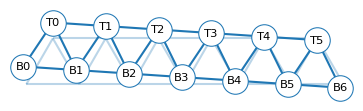

In [76]:
draw_truss_graph(G, subs, label_nodes=False, alpha=0.3)
draw_truss_graph(G_rot, subs)

And we can see that this null vector represents the third degree of freedom, rotation.

With 10 unknowns and only 7 independent equations, this system is **underdetermined**, which means it has many possible solutions.
But that's because we have not yet taken into account all of the information we have about the physical scenario -- specifically, we know that two of the nodes are fixed in space.

## Reduce the Matrix

Let's assume that the truss is attached firmly at the left and right.
The following loop makes a new version of the graph where the displacement at those nodes is zero.

In [77]:
fixed_nodes = ['B0', f'B{N}']
G_fixed = G.copy()

for node in G.nodes():
    if node in fixed_nodes:
        disp = make_vector(0, 0)
        gset(G_fixed, node, disp=disp)

Since these displacements are no longer unknown, we can remove them from the matrix equation.
First, we'll compute the indices of the remaining nodes that are not fixed.

In [78]:
keep = [gget(G_fixed, node, 'index') 
        for node in G_fixed.nodes 
        if node not in fixed_nodes]

keep    

[1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12]

Now we'll select the blocks that correspond to these nodes.

In [79]:
blocks_reduced = [
    [blocks[i][j] 
     for j in keep]
     for i in keep
]

And make a new block matrix that has been **reduced** by removing the known displacements.

In [80]:
K_reduced = sp.BlockMatrix(blocks_reduced)
factor_matrix(K_reduced, k/4)

(A*E/(4*L))*Matrix([
[                          Matrix([
[10, 0],
[ 0, 6]]),                           Matrix([
[-4, 0],
[ 0, 0]]),                             Matrix([
[0, 0],
[0, 0]]),                             Matrix([
[0, 0],
[0, 0]]),                             Matrix([
[0, 0],
[0, 0]]), Matrix([
[     -1, sqrt(3)],
[sqrt(3),      -3]]), Matrix([
[      -1, -sqrt(3)],
[-sqrt(3),       -3]]),                             Matrix([
[0, 0],
[0, 0]]),                             Matrix([
[0, 0],
[0, 0]]),                             Matrix([
[0, 0],
[0, 0]]),                             Matrix([
[0, 0],
[0, 0]])],
[                          Matrix([
[-4, 0],
[ 0, 0]]),                           Matrix([
[10, 0],
[ 0, 6]]),                           Matrix([
[-4, 0],
[ 0, 0]]),                             Matrix([
[0, 0],
[0, 0]]),                             Matrix([
[0, 0],
[0, 0]]),                         Matrix([
[0, 0],
[0, 0]]),     Matrix([
[     -1, sqrt(3)],
[sqrt(3),      -

Now there are only 6 columns, and it has **full rank** -- that is, the equations it represents are independent. 

In [81]:
K_reduced.as_explicit().rank()

22

And that means the equation $K u = f$ has a unique solution for any vector of forces, $f$. 

To solve the system, we'll loop through the reduced graph to collect the unknown displacements.

In [82]:
u_reduced = get_block_vector(G_fixed, 'disp', keep)
u_reduced

Matrix([
[Matrix([
[u_B1_x],
[u_B1_y]])],
[Matrix([
[u_B2_x],
[u_B2_y]])],
[Matrix([
[u_B3_x],
[u_B3_y]])],
[Matrix([
[u_B4_x],
[u_B4_y]])],
[Matrix([
[u_B5_x],
[u_B5_y]])],
[Matrix([
[u_T0_x],
[u_T0_y]])],
[Matrix([
[u_T1_x],
[u_T1_y]])],
[Matrix([
[u_T2_x],
[u_T2_y]])],
[Matrix([
[u_T3_x],
[u_T3_y]])],
[Matrix([
[u_T4_x],
[u_T4_y]])],
[Matrix([
[u_T5_x],
[u_T5_y]])]])

And we can collect the external forces the same way.

In [83]:
f_reduced = get_block_vector(G_fixed, 'f_ext', keep)
f_reduced

Matrix([
[Matrix([
[ 0],
[-F]])],
[  Matrix([
[0],
[0]])],
[  Matrix([
[0],
[0]])],
[  Matrix([
[0],
[0]])],
[  Matrix([
[0],
[0]])],
[  Matrix([
[0],
[0]])],
[  Matrix([
[0],
[0]])],
[  Matrix([
[0],
[0]])],
[  Matrix([
[0],
[0]])],
[  Matrix([
[0],
[0]])],
[  Matrix([
[0],
[0]])]])

And now (finally!) we are ready to solve the system.
Here's the matrix equation, $K u = f$.

In [84]:
eq = sp.Eq(K_reduced * u_reduced, f_reduced)

We can use `subs` again to replace the symbols with their values.

In [85]:
eq_num = eq.subs(subs)

The result is a numerical matrix equation we can solve for the unknown displacements.

In [86]:
sol = sp.solve(eq_num, u_reduced.as_explicit())

Here's what the result looks like.

In [87]:
u_sol = u_reduced.subs(sol)
sp.Eq(u_reduced, factor_matrix(u_sol, 1e-6))

Eq(Matrix([
[Matrix([
[u_B1_x],
[u_B1_y]])],
[Matrix([
[u_B2_x],
[u_B2_y]])],
[Matrix([
[u_B3_x],
[u_B3_y]])],
[Matrix([
[u_B4_x],
[u_B4_y]])],
[Matrix([
[u_B5_x],
[u_B5_y]])],
[Matrix([
[u_T0_x],
[u_T0_y]])],
[Matrix([
[u_T1_x],
[u_T1_y]])],
[Matrix([
[u_T2_x],
[u_T2_y]])],
[Matrix([
[u_T3_x],
[u_T3_y]])],
[Matrix([
[u_T4_x],
[u_T4_y]])],
[Matrix([
[u_T5_x],
[u_T5_y]])]]), 1.0e-6*Matrix([
[Matrix([
[                0],
[-113.425925925926]])],
[Matrix([
[ 9.43005439676389],
[-128.851851851852]])],
[Matrix([
[ 14.1450815951458],
[-114.333333333333]])],
[Matrix([
[ 14.1450815951458],
[-80.7592592592593]])],
[Matrix([
[ 9.43005439676389],
[-39.0185185185185]])],
[  Matrix([
[51.0794613158044],
[-56.712962962963]])],
[Matrix([
[ 27.5043253238947],
[-123.861111111111]])],
[Matrix([
[  8.6442165303669],
[-122.953703703704]])],
[Matrix([
[-5.50086506477893],
[-97.5462962962963]])],
[Matrix([
[-14.9309194615428],
[-58.5277777777778]])],
[Matrix([
[-19.6459466599248],
[ -16.787037037037]])]]))

And here's what those displacements look like, scaled up by a factor of 300 to make them visible.

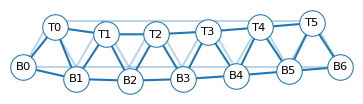

In [88]:
G_sol = displace_truss(G_fixed, sol, scale=300)

draw_truss_graph(G, subs, label_nodes=False, alpha=0.3)
draw_truss_graph(G_sol, subs)

At `B1`, the displacement in the `y` direction is about 41 micrometers, which is about twice the displacement we computed for the simple truss.
And that makes sense because the span of this truss is about twice the span of the simple truss.

If you go back where we defined `N = 2`, you can set `N` to another value and run the notebook again.
See what happens to the results as you increase `N`.

## Discussion

When I was an undergraduate, I took a class where we learned to analyze trusses.
One of my classmates asked a question that I'm not sure I appreciated at the time, but it stuck with me.
To paraphrase, he asked, "Do we design trusses because they are optimal, or because they are easy to analyze?"
This is a really good question.

As you might guess, the answer is both.
If your goal is to build a structure that supports a given load with a minimum amount of material, a truss may not be optimal -- with the complexity of real-world requirements and constraints, it's hard to say what "optimal" even means.
But for many applications, a truss is a fundamentally good design.

It is also easy to analyze, but that is not as important as it used to be.
Before we had computers, we analyzed structures by hand, so we had to keep them simple.
When I was an undergraduate, we had enough computational power and software capability to analyze more complex structures, but what we could design was still limited by what we could analyze.

Now with modern computational tools, we can analyze almost any structure we can imagine, so analysis is no longer the limiting factor on what we can design and build.
But this is a recent change, and we are only beginning to see its consequences.

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)